In [1]:
from fastcore.all import *
from duckduckgo_search import DDGS #  Web-Recherche, Bildersuche oder Datensammlung

## Get Data

In [2]:
def search_images(keywords, max_images=200): 
    return L(DDGS().images(keywords=keywords, max_results=max_images)).itemgot('image')

In [3]:
# test image suche
urls = search_images('bird photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg?cs=srgb&dl=pexels-roshan-kamath-1661179.jpg&fm=jpg'

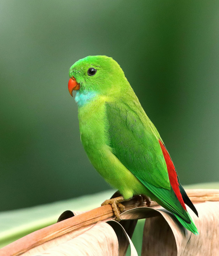

In [4]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(url=urls[0], dest=dest, show_progress=False)


from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

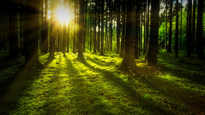

In [5]:
download_url(url=search_images('forest photos', max_images=1)[0], dest='forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(205,205)

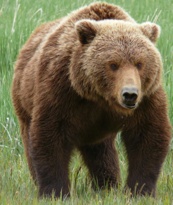

In [6]:
download_url(url=search_images('grizzly bear', max_images=1)[0], dest='grizzly bear.jpg', show_progress=False)
Image.open('grizzly bear.jpg').to_thumb(205,205)

In [7]:
path = Path('bears')

In [8]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

if not path.exists():
    path.mkdir()

for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} bear photo'))
    time.sleep(5)


In [9]:
fns = get_image_files(path)
len(fns) # # zeigt Liste aller Bilder (Länge)

542

In [10]:
# Fehlerhafte Bilder erkennen und löschen
failed = verify_images(fns)
failed.map(Path.unlink)  # löscht die kaputten Bilder

/home/lukelo-tshakulongo/Bankoko/φ-σ-Ω/Computer Science/Code/Mulandu/DLConcepts/venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/lukelo-tshakulongo/Bankoko/φ-σ-Ω/Computer Science/Code/Mulandu/DLConcepts/venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/lukelo-tshakulongo/Bankoko/φ-σ-Ω/Computer Science/Code/Mulandu/DLConcepts/venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/lukelo-tshakulongo/Bankoko/φ-σ-Ω/Computer Science/Code/Mulandu/DLConcepts/venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/lukelo-tshakulongo/Bankoko/φ-σ

(#26) [None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None...]

In [11]:
len(failed)

26

In [12]:
# DataBlock/DataLoader

bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),                  # Datentypen: Bilder + Kategorien
    get_items=get_image_files,                           # Wie man die Dateien findet
    splitter=RandomSplitter(valid_pct=0.2, seed=42),     # Trainings-/Validierungs-Split
    get_y=parent_label,                                  # Wie man das Label bekommt
    item_tfms=Resize(128)                                # Bilder auf gleiche Größe bringen
)

In [13]:
dls = bears.dataloaders(path) # angeben, wo unsere Bilder liegen

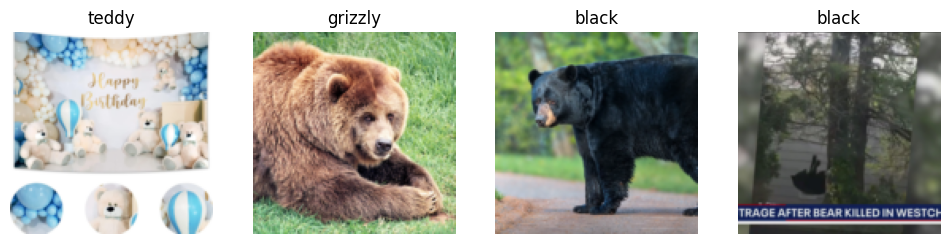

In [14]:
dls.valid.show_batch(max_n=4, nrows=1)

## Resize-Varianten – und ihre Probleme

Standardmäßig werden Bilder beschnitten (Crop), um sie quadratisch zu machen. Aber bei Crop wichtige Bildteile gehen verloren.

### RandomResizedCrop
* Bei jedem Durchgang („Epoch“) wird ein anderer Bildausschnitt verwendet.

* Das Modell lernt: Objekte können unterschiedlich groß / positioniert sein.



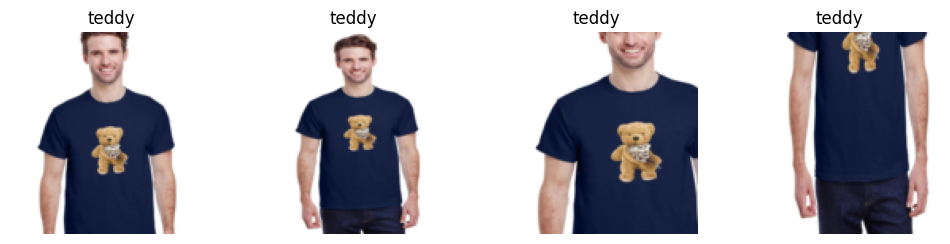

In [15]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))

dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation (Daten künstlich variieren)
* Ziel: Modelle robuster machen, ohne mehr echte Daten zu sammeln.


Stell dir vor, du willst einem Modell beibringen, Bären auf Fotos zu erkennen – aber du hast nur 100 echte Bilder.
Data Augmentation bedeutet: Du erzeugst aus diesen 100 Fotos viele verschiedene Varianten, damit das Modell mehr sieht – ohne neue Bilder zu sammeln.

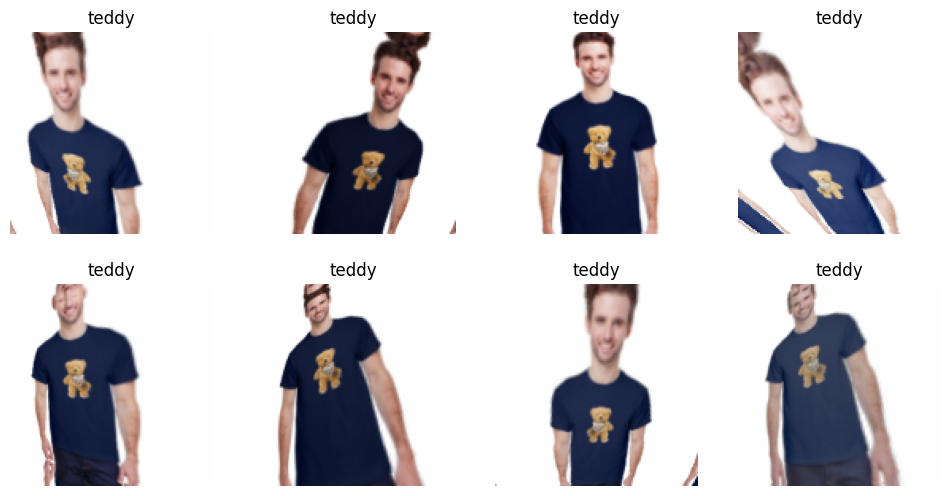

In [16]:
bears = bears.new(
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(mult=2)  # doppelte Intensität für Lernzwecke
)
dls = bears.dataloaders(path, device='cpu')
dls.train.show_batch(max_n=8, nrows=2, unique=True)


## Train the model
Da wir nur wenige Bilder pro Bärenart haben (~150), wählen wir folgende Parameter:

In [17]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),  # Standard-Bildgröße für Klassifikation
    batch_tfms=aug_transforms()                        # Bildverzerrungen zur Robustheit
)
dls = bears.dataloaders(path, bs=8, device='cpu')

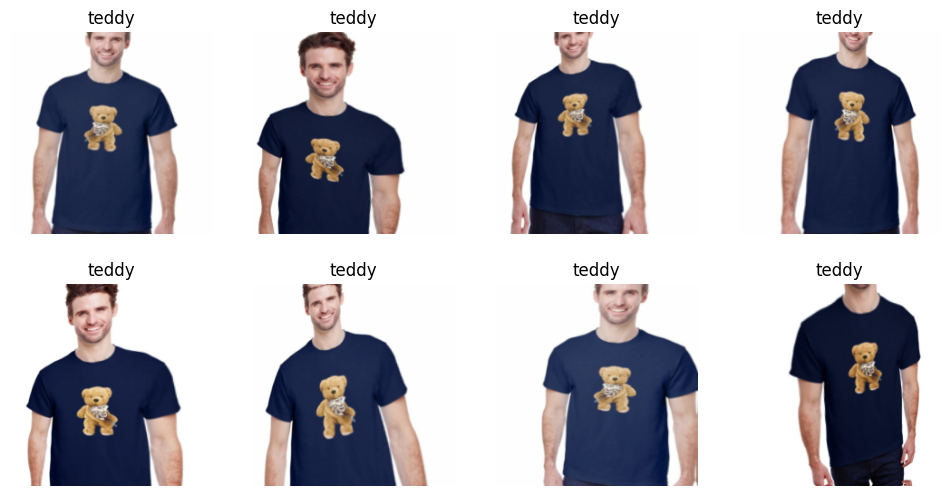

In [18]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [19]:
import torch

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.model = learn.model.cpu()
learn.dls.device = torch.device('cpu')

learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.901419,0.246909,0.087379,00:31


/home/lukelo-tshakulongo/Bankoko/φ-σ-Ω/Computer Science/Code/Mulandu/DLConcepts/venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.741524,0.220530,0.077670,00:50
1,0.460813,0.169455,0.077670,00:45
2,0.362740,0.186107,0.058252,00:45
3,0.319626,0.176000,0.067961,00:45


/home/lukelo-tshakulongo/Bankoko/φ-σ-Ω/Computer Science/Code/Mulandu/DLConcepts/venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/lukelo-tshakulongo/Bankoko/φ-σ-Ω/Computer Science/Code/Mulandu/DLConcepts/venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/lukelo-tshakulongo/Bankoko/φ-σ-Ω/Computer Science/Code/Mulandu/DLConcepts/venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/lukelo-tshakulongo/Bankoko/φ-σ-Ω/Computer Science/Code/Mulandu/DLConcepts/venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### Fehler analysieren: Wo liegt das Problem?
* Diagonale = korrekt klassifizierte Bilder

* Off-Diagonale = falsch klassifizierte Bilder
* Ziel: möglichst viele Bilder auf der Diagonale!



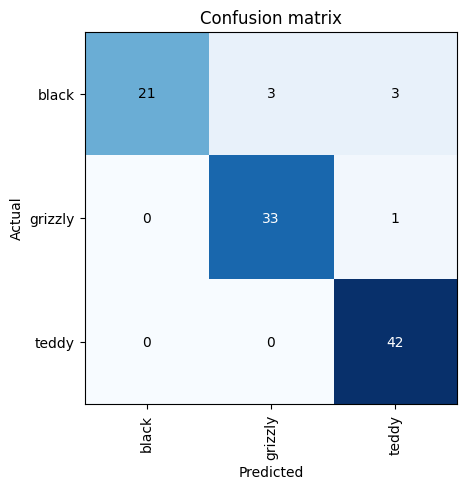

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Top-Fehler analysieren
Jedes Bild zeigt:

* Vorhersage

* Tatsächliches Label

* Verlustwert (Loss)

* Wahrscheinlichkeit

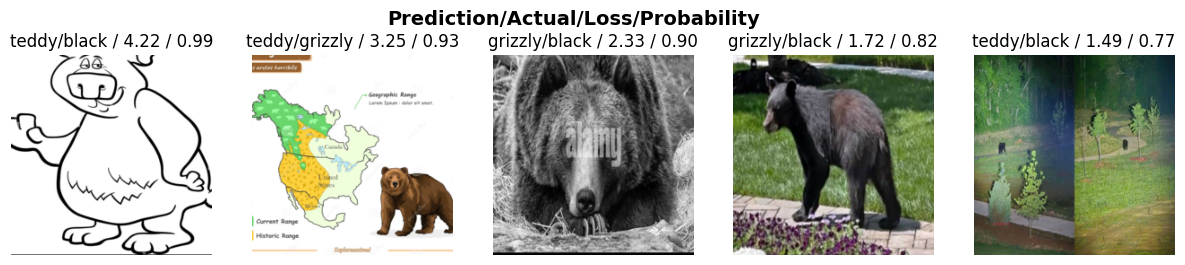

In [21]:
interp.plot_top_losses(5, nrows=1)

### Modellgestützte Datenbereinigung
Klassisch bereinigt man Daten vorher –
aber mit einem trainierten Modell geht’s oft schneller & gezielter.

In [22]:
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learn)
cleaner

/home/lukelo-tshakulongo/Bankoko/φ-σ-Ω/Computer Science/Code/Mulandu/DLConcepts/venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [23]:
import shutil  # <– Das ist notwendig für .move()

for idx in cleaner.delete():
    try:
        cleaner.fns[idx].unlink()
    except FileNotFoundError:
        print(f"⚠️ Datei bereits gelöscht: {cleaner.fns[idx]}")

In [24]:
learn.export('bears_cleaned.pkl')

In [33]:
path.ls(file_exts='.pkl')

(#1) [Path('bears/bears_cleaned.pkl')]

## Model hochladen

In [43]:
from fastai.learner import load_learner

learn_inf = load_learner('bears_cleaned.pkl')  # oder den korrekten Pfad zu deinem exportierten Modell

* 'grizzly' → vorhergesagte Klasse

* tensor(1) → Index in learn_inf.dls.vocab

* tensor([...]) → Wahrscheinlichkeiten für jede Klasse

In [44]:
learn_inf.predict('bears/grizzly bear.jpg')

('grizzly', tensor(1), tensor([1.8795e-05, 9.9998e-01, 6.0915e-06]))

In [46]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

## Interaktive Web-App direkt im Jupyter Notebook

In [56]:
from fastai.vision.all import *
from ipywidgets import FileUpload, Output
from IPython.display import display

btn_upload = FileUpload(accept='image/*', multiple=False)
display(btn_upload)

FileUpload(value=(), accept='image/*', description='Upload')

In [58]:
img_bytes = btn_upload.value[0]['content']
img = PILImage.create(bytes(img_bytes))  # ✅ wichtig

out = Output()
with out:
    display(img.to_thumb(128,128))
    pred, pred_idx, probs = learn_inf.predict(img)
    print(f" Vorhersage: {pred} ({probs[pred_idx]:.2%})")
out


Output()

In [59]:
pred, pred_idx, probs = learn_inf.predict(img)

lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: black; Probability: 1.0000')

In [60]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
from fastai.vision.all import *
from ipywidgets import VBox, HBox, Button, Label, Output, FileUpload
from IPyGesetz13/DogCaton.display import display

# Upload-Button und Run-Button
btn_upload = FileUpload(accept='image/*', multiple=False)
btn_run = Button(description='Classify')

# Bildausgabe und Vorhersage-Ausgabe
out_pl = Output()
lbl_pred = Label()

# Klassifikation auf Klick
def on_click_classify(change):
    out_pl.clear_output()
    if btn_upload.value:
        img_bytes = btn_upload.value[0]['content']
        img = PILImage.create(bytes(img_bytes))
        with out_pl:
            display(img.to_thumb(128, 128))
            pred, pred_idx, probs = learn_inf.predict(img)
            lbl_pred.value = f'✅ Vorhersage: {pred} ({probs[pred_idx]:.2%})'
    else:
        lbl_pred.value = "⚠️ Kein Bild hochgeladen."

btn_run.on_click(on_click_classify)

# UI anzeigen
VBox([
    Label('🐻 Wähle ein Bild von einem Bären!'),
    btn_upload,
    btn_run,
    out_pl,
    lbl_pred
])